## Installing Dependencies
The initial cells ensure that the necessary Python libraries are installed. These include:

- `numpy` for numerical computations
- `matplotlib` for visualization
- `gymnasium` for simulating the Pong environment
- `ale-py` for Atari Learning Environment (ALE) support


These installations allow the notebook to run reinforcement learning experiments using the Pong game environment.


In [1]:
!pip install numpy matplotlib

In [2]:
!pip install gymnasium[atari,accept-rom-license] --upgrade

In [3]:
# Install dependencies if needed (uncomment the next line)
# !pip install gym torch numpy matplotlib
!pip install ale-py

In [4]:
!pip install autorom[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446711 sha256=582b552f65d7f556f54b343d5f1b8a57e206ed46beefcc3088894dae37701818
  Stored in directory: /root/.cache/pip/wheels/bc/fc/c6/8aa657c0d2089982f2dabd110efc68c61eb49831fdb7397351
Successfully built AutoROM.accept-rom-license


In [5]:
!pip install atari_py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.6/540.6 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for atari_py: filename=atari_py-0.2.9-cp311-cp311-linux_x86_64.whl size=2871997 sha256=13b0c8bbeb651d914f577540f32723ff0cc1e88fa064413e8835e5beacbab38c
  Stored in directory: /root/.cache/pip/wheels/88/bb/c9/355a2560e9a75e6800cd54c37a19ca22badc1cf6a8b4a34c1b
Successfully built atari_py


In [6]:
!pip install ale-py
!pip install autorom[accept-rom-license]

In [7]:
!pip install pyvirtualdisplay
!apt-get install -y xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 29 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 12.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

## Importing Required Libraries
After installing dependencies, the script imports necessary modules:

- `gymnasium` provides the Pong environment.
- `numpy` is used for numerical operations.
- `matplotlib.pyplot` is used for visualization.
- `torch`, `torch.nn`, and `torch.optim` are used for implementing the neural network model and optimization.



In [8]:
### Step 1: Setup and Dependencies
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import atari_py  # Import atari_py to register the Atari environments
import ale_py # import ale_py package

## Setting Up the Pong Environment

The script initializes the Pong environment using `gym.make()`:

- The environment is created using `ALE/Pong-v5`.
- `render_mode='rgb_array'` ensures that the environment renders frames as images.
- `env.action_space.n` retrieves the number of possible actions the agent can take in the game.



In [9]:
# Initialize environment

env = gym.make("ALE/Pong-v5", render_mode="rgb_array") # Changed environment ID

In [10]:
print("Observation space:", env.observation_space.shape)  # (210, 160, 3)
print("Action space:", env.action_space.n)  # 6 actions

Observation space: (210, 160, 3)
Action space: 6


## Defining the Deep Q-Network (DQN)

A neural network is used to approximate the Q-function, which estimates the expected reward for each action.

- Uses convolutional layers to extract spatial features.
- Fully connected layers map the extracted features to action values.



In [11]:
### Step 2: Define the Neural Network

# Define CNN-based DQN Model
class CNN_DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CNN_DQN, self).__init__()

        # Define Convolutional Layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),  # Output: (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # Output: (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # Output: (64, 7, 7)
            nn.ReLU(),
        )

        # Fully Connected Layers
        # The output from the last convolution layer has the size: (64, 7, 7), so the input size to the fully connected layer should be 64*7*7
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),  # Flattening (64 * 7 * 7 = 3136)
            nn.ReLU(),
            nn.Linear(512, num_actions)  # Output size: num_actions (number of possible actions)
        )

    def forward(self, x):
        x = self.conv_layers(x)  # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the output to (batch_size, 3136)
        return self.fc_layers(x)  # Pass through fully connected layers


In [12]:
# Initialize policy and target networks
policy_net = CNN_DQN(env.observation_space.shape, env.action_space.n)
target_net = CNN_DQN(env.observation_space.shape, env.action_space.n)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Optimizer and loss function
optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Exploration parameters
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
gamma = 0.99

# Experience Replay
replay_memory = deque(maxlen=100000)



## Preprocessing Frames

To simplify input to the neural network, frames are converted to grayscale and resized:

- Crops the frame to remove unnecessary areas.
- Converts the frame to grayscale by averaging color channels.
- Downsamples the image to reduce computational complexity.


In [13]:
# Function to preprocess frames
import cv2

def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    frame = cv2.resize(frame, (84, 84))  # Resize
    return frame / 255.0  # Normalize

# Function to stack frames
def stack_frames(frames, new_frame, is_new=False):
    processed_frame = preprocess_frame(new_frame)
    if is_new:
        return np.stack([processed_frame] * 4, axis=0)
    else:
        frames[:-1] = frames[1:]  # Shift frames left
        frames[-1] = processed_frame
        return frames


In [14]:


import numpy as np

# This is specific to the pong environment
def img_crop(img):
    return img[30:-12,:,:]

# GENERAL Atari preprocessing steps
def downsample(img):
    # We will take only half of the image resolution
    return img[::2, ::2]

def transform_reward(reward):
    return np.sign(reward)

def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)

# Normalize grayscale image from -1 to 1.
def normalize_grayscale(img):
    return (img - 128) / 128 - 1

def process_frame(img, image_shape):
    img = img_crop(img)
    img = downsample(img)    # Crop and downsize (by 2)
    img = to_grayscale(img)       # Convert to greyscale by averaging the RGB values
    img = normalize_grayscale(img)  # Normalize from -1 to 1.

    return np.expand_dims(img.reshape(image_shape[0], image_shape[1], 1), axis=0)

In [17]:
env = gym.make("ALE/Pong-v5", render_mode="rgb_array") # Changed environment ID
obs, _ = env.reset()


array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       ...,

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]]], dtype=uint8)
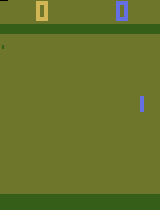

In [18]:
obs

In [19]:
processed_obs = process_frame(obs, (84, 80))  # Process the image

In [20]:
from collections import deque

# Initialize 4-frame stack
frame_stack = deque([processed_obs] * 4, maxlen=4)

# Convert stack to NumPy array for CNN input
stacked_state = np.array(frame_stack).reshape(1, 84, 80, 4)


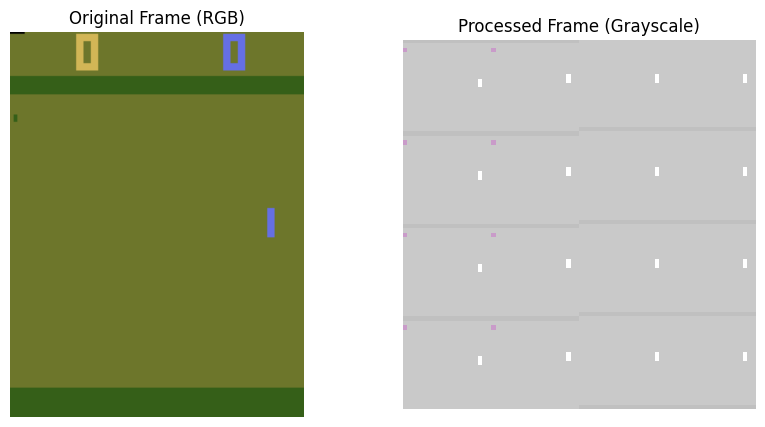

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Original Frame
ax[0].imshow(obs)
ax[0].set_title("Original Frame (RGB)")
ax[0].axis("off")

# Processed Frame
ax[1].imshow(stacked_state.squeeze(), cmap="gray")
ax[1].set_title("Processed Frame (Grayscale)")
ax[1].axis("off")

plt.show()

# Calculate Rewards

In [22]:
def custom_reward(obs, reward, done, info):
    """
    Calculates a custom reward based on game events.

    Args:
        obs (np.ndarray): The current observation of the environment.
        reward (float): The original reward from the environment.
        done (bool): Whether the episode is done.
        info (dict): Information about the game state.

    Returns:
        float: The custom reward.
    """

    # Get coordinates of objects (replace with logic specific to the game)
    ball_x = info.get("ball_x", 0)  # Replace "ball_x" with the actual key in 'info'
    ball_y = info.get("ball_y", 0)  # Replace "ball_y" with the actual key in 'info'
    paddle_x = info.get("paddle_x", 0)  # Replace "paddle_x" with the actual key in 'info'
    paddle_y = info.get("paddle_y", 0)  # Replace "paddle_y" with the actual key in 'info'

    # Define events and calculate reward
    ball_hits_paddle = abs(ball_x - paddle_x) < 5 and abs(ball_y - paddle_y) < 5
    ball_missed = ball_x < paddle_x  # Ball passed the paddle
    agent_moves_correctly = (ball_y - paddle_y) * info.get("paddle_velocity", 0) > 0 # Paddle moving towards the ball

    # Calculate reward
    custom_reward = reward  # Start with the original reward

    if ball_hits_paddle:
        custom_reward += 0.1  # Small positive reward for hitting the ball

    if ball_missed:
        custom_reward -= 0.1  # Small penalty for missing

    if agent_moves_correctly:
        custom_reward += 0.05  # Encourage movement in the correct direction

    return custom_reward


## Train the Agent

The training loop involves:

- Collecting experience by interacting with the environment.
- Storing experiences in a replay buffer.
- Sampling from the buffer to train the DQN.
- Runs multiple episodes where the agent interacts with the game.
- Selects an action using the current policy.
- Stores experiences and updates the model.



In [23]:
### Step 7: Train the Agent

num_episodes = 10
batch_size = 8
target_update_freq = 1
episode_rewards = []

# Training loop
for episode in range(num_episodes):
    state, _ = env.reset()
    state = stack_frames(None, state, is_new=True) # Stack initial frames
    total_reward = 0
    done = False

    while not done:
        # Choose action
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)  # Convert state to tensor and add batch dimension

        if random.random() < epsilon:
            action = env.action_space.sample() # Explore
        else:
          with torch.no_grad():  # Disable gradient calculation
                action = torch.argmax(policy_net(state_tensor)).item()  # Exploit

        # Take action
        # The env.step() function now returns 5 values: observation, reward, terminated, truncated, info
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = stack_frames(state, next_state) # Stack new frame

        # Use terminated or truncated to check if the episode is done
        done = terminated or truncated

        obs, reward, terminated, truncated, info = env.step(action)
        reward = custom_reward(obs, reward, done, info)


        # Store in replay memory
        replay_memory.append((state, action, reward, next_state, done))

        # Sample from replay memory and train
        if len(replay_memory) > batch_size:
            # ... (code to sample from replay memory, calculate Q-values, loss, etc.) ...
            pass

        state = next_state # Update state

        # Update the total reward for the episode
        total_reward += reward

        # Update epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        # Update target network periodically
        if episode % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

      # Print total reward at the end of the episode
    if episode % 1 == 0:
        print(f"Episode {episode}: Reward = {total_reward}, Epsilon = {epsilon:.3f}")

Episode 0: Reward = 30.900000000000244, Epsilon = 0.122
Episode 1: Reward = 31.80000000000024, Epsilon = 0.050
Episode 2: Reward = 30.300000000000217, Epsilon = 0.050
Episode 3: Reward = 30.300000000000217, Epsilon = 0.050
Episode 4: Reward = 30.400000000000237, Epsilon = 0.050
Episode 5: Reward = 30.300000000000217, Epsilon = 0.050
Episode 6: Reward = 27.300000000000175, Epsilon = 0.050
Episode 7: Reward = 27.300000000000175, Epsilon = 0.050
Episode 8: Reward = 27.300000000000175, Epsilon = 0.050
Episode 9: Reward = 27.300000000000175, Epsilon = 0.050


# Visualize the Environment

Finally, the script evaluates the trained agent and visualizes its performance using `matplotlib`.

- Runs the trained model in the environment.
- Displays the game frame-by-frame.

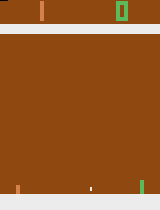

In [24]:
import gymnasium as gym
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from PIL import Image
import time

display = Display(visible=0, size=(400, 300))
display.start()

env = gym.make("ALE/Pong-v5", render_mode="rgb_array")

state, info = env.reset()
for _ in range(100):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    try:
       img = env.render()
       if img is not None:
           img = Image.fromarray(img)
           ipythondisplay.display(img)
           ipythondisplay.clear_output(wait=True)
           time.sleep(0.5)
    except Exception as e:
       print(f"Error during rendering: {e}")

display.stop()
env.close()

## Conclusion
This notebook implements a Deep Q-Network (DQN) to train an AI agent for Pong. It preprocesses game frames, defines a neural network, trains using reinforcement learning, and visualizes performance.

